<a href="https://colab.research.google.com/github/tanishupretiv2/Stock-Closing-Price-Prediction/blob/main/StockClosingPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Fetching data for META from 2021-01-18 to 2025-01-17.

Engineering features...
Training the model...


Model training complete.
MAE: 1.04, RMSE: 1.30, R2: 1.00

Next Week's Predictions:
Day 1: 616.54
Day 2: 616.13
Day 3: 615.62
Day 4: 614.78
Day 5: 611.30
Day 6: 615.49
Day 7: 614.77

Next Month's Predictions:
Day 1 (2025-01-16): 616.54
Day 2 (2025-01-17): 616.13
Day 3 (2025-01-18): 615.62
Day 4 (2025-01-19): 614.78
Day 5 (2025-01-20): 611.30
Day 6 (2025-01-21): 615.49
Day 7 (2025-01-22): 614.77
Day 8 (2025-01-23): 614.74
Day 9 (2025-01-24): 613.39
Day 10 (2025-01-25): 614.22
Day 11 (2025-01-26): 613.39
Day 12 (2025-01-27): 605.51
Day 13 (2025-01-28): 606.13
Day 14 (2025-01-29): 606.11
Day 15 (2025-01-30): 604.38
Day 16 (2025-01-31): 604.33
Day 17 (2025-02-01): 602.99
Day 18 (2025-02-02): 602.36
Day 19 (2025-02-03): 602.36
Day 20 (2025-02-04): 602.44
Day 21 (2025-02-05): 602.44
Day 22 (2025-02-06): 598.92
Day 23 (2025-02-07): 599.54
Day 24 (2025-02-08): 599.54
Day 25 (2025-02-09): 599.54
Day 26 (2025-02-10): 599.27
Day 27 (2025-02-11): 599.27
Day 28 (2025-02-12): 599.27
Day 29 (2025-02-1

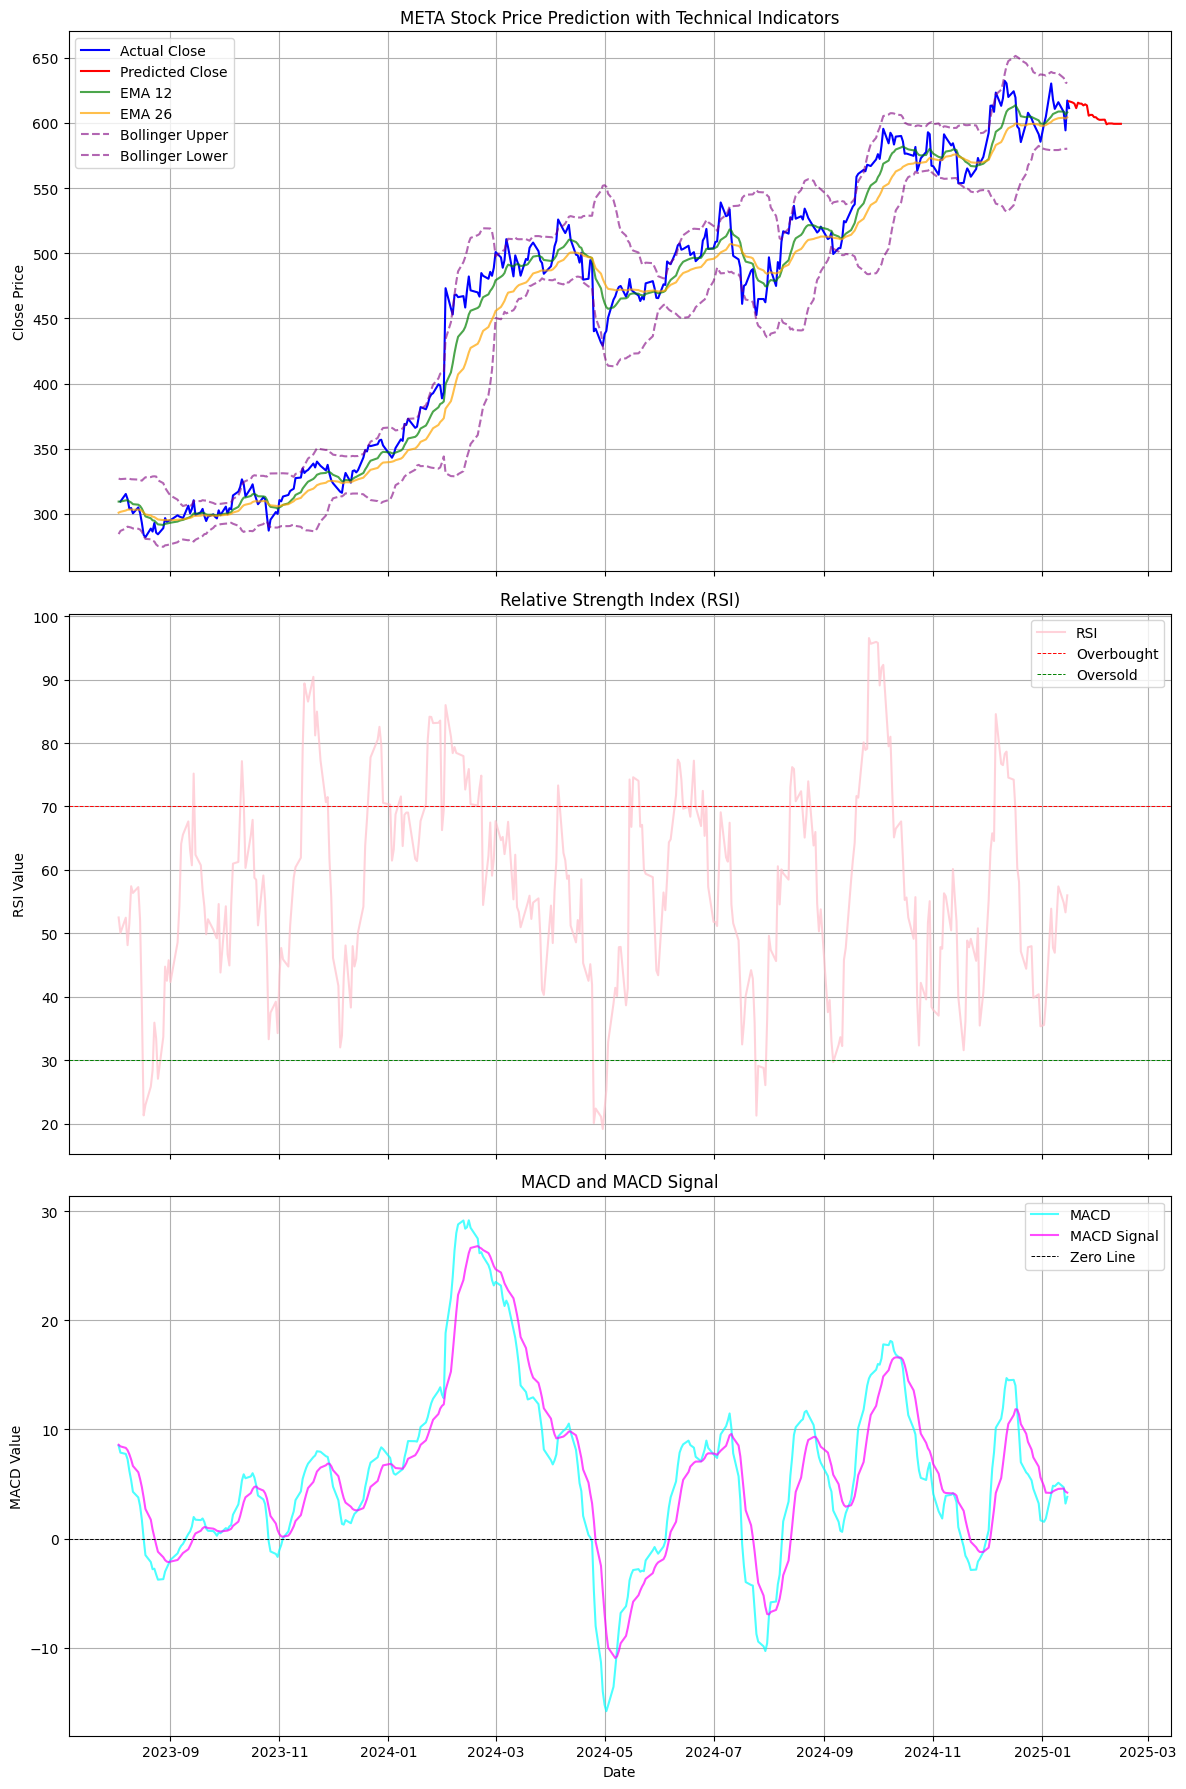

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import datetime
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.utils.validation import check_X_y

warnings.simplefilter(action="ignore", category=FutureWarning)

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    print(f"\nFetching data for {stock_symbol} from {start_date} to {end_date}.")
    try:
        data = yf.download(stock_symbol, start=start_date, end=end_date)
        if data.empty:
            print("No data retrieved.")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Function to engineer features
def engineer_features(data):
    print("\nEngineering features...")
    close = data['Close'].fillna(method='ffill')

    # Exponential Moving Averages (EMA)
    EMA_12 = close.ewm(span=12, adjust=False).mean()
    EMA_26 = close.ewm(span=26, adjust=False).mean()

    # Bollinger Bands
    SMA_20 = close.rolling(window=20).mean()
    rolling_std = close.rolling(window=20).std()
    Bollinger_Upper = SMA_20 + (2 * rolling_std)
    Bollinger_Lower = SMA_20 - (2 * rolling_std)

    # MACD
    MACD = EMA_12 - EMA_26
    MACD_Signal = MACD.ewm(span=9, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + rs))

    # Lagging features
    lags = pd.concat([close.shift(i) for i in range(1, 6)], axis=1)
    lags.columns = [f"Lag_{i}" for i in range(1, 6)]

    # Combine features into a DataFrame
    features = pd.concat([close, EMA_12, EMA_26, Bollinger_Upper, Bollinger_Lower, MACD, MACD_Signal, RSI, lags], axis=1)
    features.columns = ['Close', 'EMA_12', 'EMA_26', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'RSI'] + list(lags.columns)

    # Target variable
    target = close.shift(-1)

    # Drop NaN values
    data_cleaned = pd.concat([features, target], axis=1).dropna()
    features_cleaned = data_cleaned.drop(columns=['Close'])
    target_cleaned = data_cleaned['Close']

    return features_cleaned, target_cleaned, rolling_std

# Function to train the model
def train_model(features, target):
    print("Training the model...")

    # Ensure features and target are properly formatted
    features = features.to_numpy() if isinstance(features, pd.DataFrame) else features
    target = target.to_numpy() if isinstance(target, pd.Series) else target

    # Define the model with fixed or default hyperparameters
    model = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        n_estimators=200,  # Example: fixed hyperparameter
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )

    # Train the model directly
    model.fit(features, target)

    print("Model training complete.")
    return model


# Function to make predictions
def make_predictions(model, features, rolling_std, target, steps=30):
    rolling_predictions = []
    last_data_point = features.iloc[-1:].copy()

    for _ in range(steps):
        next_pred = model.predict(last_data_point)[0]
        rolling_predictions.append(next_pred)

        # Efficiently update features
        last_data_point.iloc[0, -5:] = [next_pred] + last_data_point.iloc[0, -5:-1].tolist()
        last_data_point['EMA_12'] = next_pred * (2 / (12 + 1)) + last_data_point['EMA_12'] * (1 - (2 / (12 + 1)))
        last_data_point['EMA_26'] = next_pred * (2 / (26 + 1)) + last_data_point['EMA_26'] * (1 - (2 / (26 + 1)))
        last_data_point['MACD'] = last_data_point['EMA_12'] - last_data_point['EMA_26']
        last_data_point['MACD_Signal'] = last_data_point['MACD'] * (2 / (9 + 1)) + last_data_point['MACD_Signal'] * (1 - (2 / (9 + 1)))
        last_data_point['Bollinger_Upper'] = next_pred + (2 * rolling_std.iloc[-1])
        last_data_point['Bollinger_Lower'] = next_pred - (2 * rolling_std.iloc[-1])

    future_dates = pd.date_range(start=features.index[-1] + pd.Timedelta(days=1), periods=steps)
    predicted_data = pd.DataFrame({'Close': rolling_predictions}, index=future_dates)

    # Evaluate predictions
    y_pred = model.predict(features)
    mae = mean_absolute_error(target, y_pred)
    rmse = np.sqrt(mean_squared_error(target, y_pred))
    r2 = r2_score(target, y_pred)

    # Print evaluation metrics
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

    # Display next week's and next month's predictions
    week_predictions = rolling_predictions[:7]
    month_predictions = rolling_predictions
    prev_month_close = target[-30:]

    # Print previous month close
    prev_month_text = (
        "Previous Month Close Prices:\n" +
        "\n".join([f"Day {i} ({date.date()}): {price:.2f}" for i, (date, price) in enumerate(zip(prev_month_close.index, prev_month_close), start=1)]) +
        "\n\n"
    )

    # Print the predictions in a readable format
    print("\nNext Week's Predictions:")
    for i, pred in enumerate(week_predictions, start=1):
        print(f"Day {i}: {pred:.2f}")

    print("\nNext Month's Predictions:")
    for i, (date, pred) in enumerate(zip(future_dates, month_predictions), start=1):
        print(f"Day {i} ({date.date()}): {pred:.2f}")

    return predicted_data

# Function to plot results
def plot_results(stock_symbol, data, predicted_data, features):

    # Create subplots
    fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    # Plot actual and predicted close prices along with moving averages and Bollinger Bands on the first subplot
    ax.plot(data[-365:].index, data['Close'][-365:], label='Actual Close', color='blue')
    ax.plot(predicted_data.index, predicted_data['Close'], label='Predicted Close', color='red')
    ax.plot(features[-365:].index, features['EMA_12'][-365:], label='EMA 12', color='green', alpha=0.7)
    ax.plot(features[-365:].index, features['EMA_26'][-365:], label='EMA 26', color='orange', alpha=0.7)
    ax.plot(features[-365:].index, features['Bollinger_Upper'][-365:], label='Bollinger Upper', color='purple', linestyle='--', alpha=0.6)
    ax.plot(features[-365:].index, features['Bollinger_Lower'][-365:], label='Bollinger Lower', color='purple', linestyle='--', alpha=0.6)
    ax.set_title(f"{stock_symbol} Stock Price Prediction with Technical Indicators")
    ax.set_ylabel("Close Price")
    ax.legend()
    ax.grid(True)

    # Plot RSI on the second subplot
    ax1.plot(features[-365:].index, features['RSI'][-365:], label='RSI', color='pink', alpha=0.7)
    ax1.axhline(70, color='red', linestyle='--', linewidth=0.7, label='Overbought')
    ax1.axhline(30, color='green', linestyle='--', linewidth=0.7, label='Oversold')
    ax1.set_title("Relative Strength Index (RSI)")
    ax1.set_ylabel("RSI Value")
    ax1.legend()
    ax1.grid(True)

    # Plot MACD and MACD Signal on the third subplot
    ax2.plot(features[-365:].index, features['MACD'][-365:], label='MACD', color='cyan', alpha=0.7)
    ax2.plot(features[-365:].index, features['MACD_Signal'][-365:], label='MACD Signal', color='magenta', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=0.7, label='Zero Line')
    ax2.set_title("MACD and MACD Signal")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("MACD Value")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


# Main function
def stock_prediction(stock_symbol):
    end_date = datetime.datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.datetime.today() - datetime.timedelta(days=4 * 365)).strftime('%Y-%m-%d')  # Increased data window

    data = fetch_stock_data(stock_symbol, start_date, end_date)
    if data is not None:
        features, target, rolling_std = engineer_features(data)
        model = train_model(features, target)
        predictions = make_predictions(model, features, rolling_std, target, 30)
        plot_results(stock_symbol, data, predictions, features)

def generate_pdf_report(stock_symbols, output_filename="stock_report.pdf"):
    """
    Generates a PDF report for stock predictions with improved plots.

    Parameters:
        stock_symbols (list): List of stock symbols to process.
        output_filename (str): Name of the output PDF file.
    """
    end_date = datetime.datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.datetime.today() - datetime.timedelta(days=4 * 365)).strftime('%Y-%m-%d')

    with PdfPages(output_filename) as pdf_pages:
        for stock_symbol in stock_symbols:
            print(f"\nProcessing stock: {stock_symbol}")

            # Fetch data
            data = fetch_stock_data(stock_symbol, start_date, end_date)
            if data is None or data.empty:
                print(f"No data available for {stock_symbol}, skipping.")
                continue

            # Engineer features, train model, and make predictions
            features, target, rolling_std = engineer_features(data)
            model = train_model(features, target)
            predictions = make_predictions(model, features, rolling_std, target, 30)

            # Evaluate predictions
            y_pred = model.predict(features)
            mae = mean_absolute_error(target, y_pred)
            rmse = np.sqrt(mean_squared_error(target, y_pred))
            r2 = r2_score(target, y_pred)

            # Display next week's and next month's predictions
            rolling_predictions = predictions['Close'].values
            future_dates = predictions.index
            week_predictions = rolling_predictions[:7]
            month_predictions = rolling_predictions
            prev_month_close = target[-30:]

            # Format Previous Month Close Prices similarly to predictions
            prev_month_text = (
                "Previous Month Close Prices:\n" +
                "\n".join([f"Day {i} ({date.date()}): {price:.2f}" for i, (date, price) in enumerate(zip(prev_month_close.index, prev_month_close), start=1)]) +
                "\n\n"
            )

            next_week_predictions = (
                "Next Week's Predictions:\n" +
                "\n".join([f"Day {i}: {pred:.2f}" for i, pred in enumerate(week_predictions, start=1)]) + "\n\n"
            )

            next_month_predictions = (
                "Next Month's Predictions:\n" +
                "\n".join([f"Day {i} ({date.date()}): {pred:.2f}" for i, (date, pred) in enumerate(zip(future_dates, month_predictions), start=1)])
            )

            # Create a figure for the full text with two columns
            fig, ax = plt.subplots(figsize=(12, 12))  # Larger figure to fit all text
            ax.axis('off')  # Hide axes

            # Centered Title
            ax.text(0.5, 0.95, f"Stock: {stock_symbol}", fontsize=24, va='top', ha='center')

            # Left Column (Evaluation Metrics and Previous Month)
            evaluation_metrics = (
                f"Evaluation Metrics:\n"
                f"- Mean Absolute Error (MAE): {mae:.2f}\n"
                f"- Root Mean Squared Error (RMSE): {rmse:.2f}\n"
                f"- R² Score: {r2:.2f}\n\n"
            )

            left_column_text = evaluation_metrics + prev_month_text
            ax.text(0.01, 0.8, left_column_text, fontsize=12, va='top', ha='left', wrap=True)

            # Right Column (Next Week and Next Month Predictions)
            right_column_text = next_week_predictions + next_month_predictions
            ax.text(0.55, 0.8, right_column_text, fontsize=12, va='top', ha='left', wrap=True)

            pdf_pages.savefig(fig)  # Save the text to the PDF
            plt.close(fig)

            # Plot the actual vs predicted close prices
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

            # Subplot 1: Actual vs Predicted Close Prices and Indicators
            ax1.plot(data[-365:].index, data['Close'][-365:], label='Actual Close', color='blue')
            ax1.plot(predictions.index, predictions['Close'], label='Predicted Close', color='red')
            ax1.plot(data[-365:].index, features['EMA_12'][-365:], label='EMA 12', color='green', alpha=0.7)
            ax1.plot(data[-365:].index, features['EMA_26'][-365:], label='EMA 26', color='orange', alpha=0.7)
            ax1.plot(data[-365:].index, features['Bollinger_Upper'][-365:], label='Bollinger Upper', color='purple', linestyle='--', alpha=0.6)
            ax1.plot(data[-365:].index, features['Bollinger_Lower'][-365:], label='Bollinger Lower', color='purple', linestyle='--', alpha=0.6)
            ax1.set_title("Close Prices with EMA and Bollinger Bands")
            ax1.set_ylabel("Price")
            ax1.legend()
            ax1.grid(True)

            # Subplot 2: RSI
            ax2.plot(data[-365:].index, features['RSI'][-365:], label='RSI', color='pink', alpha=0.7)
            ax2.axhline(70, color='red', linestyle='--', linewidth=0.7, label='Overbought')
            ax2.axhline(30, color='green', linestyle='--', linewidth=0.7, label='Oversold')
            ax2.set_title("Relative Strength Index (RSI)")
            ax2.set_ylabel("RSI Value")
            ax2.legend()
            ax2.grid(True)

            # Subplot 3: MACD and MACD Signal
            ax3.plot(data[-365:].index, features['MACD'][-365:], label='MACD', color='cyan', alpha=0.7)
            ax3.plot(data[-365:].index, features['MACD_Signal'][-365:], label='MACD Signal', color='magenta', alpha=0.7)
            ax3.axhline(0, color='black', linestyle='--', linewidth=0.7, label='Zero Line')
            ax3.set_title("MACD and MACD Signal")
            ax3.set_xlabel("Date")
            ax3.set_ylabel("MACD Value")
            ax3.legend()
            ax3.grid(True)

            plt.tight_layout()
            pdf_pages.savefig()  # Save the current plot to the PDF
            plt.close()

    print(f"\nPDF report generated: {output_filename}")


# Test the function without PDF
stock_prediction("META")

#Test singular stock with PDF
#generate_pdf_report(["META"], output_filename="META_report.pdf")

#Test multiple with PDF
#generate_pdf_report([
  ## NASDAQ
  #"AAPL",  # Apple
  #"MSFT",  # Microsoft
  #"GOOG",  # Alphabet (Google)
  #"AMZN",  # Amazon
  #"META",  # Meta Platforms (Facebook)
  #"NVDA",  # NVIDIA
  #"TSLA",  # Tesla

  ## Consumer Goods
  #"KO",  # Coca-Cola
  #"PEP",  # PepsiCo
  #"PG",  # Procter & Gamble
  #"UL",  # Unilever

  ## Healthcare
  #"PFE",  # Pfizer
  #"MRNA",  # Moderna
  #"JNJ",  # Johnson & Johnson
  #"BIIB",  # Biogen

  ## Financials
  #"JPM",  # JPMorgan Chase
  #"BAC",  # Bank of America
  #"BRK-B",  # Berkshire Hathaway
  #"V",  # Visa
  #"PYPL",  # PayPal

  ## Energy
  #"XOM",  # Exxon Mobil
  #"CVX",  # Chevron
  #"NEE",  # NextEra Energy
  #"ENPH",  # Enphase Energy

  ## Industrial and Materials
  #"CAT",  # Caterpillar
  #"BA",  # Boeing
  #"FCX",  # Freeport-McMoRan
  #"UNP",  # Union Pacific

   # Emerging or Unique Stocks
  #"RIVN",  # Rivian
  #"PLTR",  # Palantir Technologies
  #"SQ",  # Block (formerly Square)
  #"ABNB",  # Airbnb
  #"DKNG",  # DraftKings

  ## International Stocks
  #"BABA",  # Alibaba
  #"TSM",  # Taiwan Semiconductor
  #"NSRGY",  # Nestlé
  #"ADDYY",  # Adidas

  ## NYSE
  #'IBM',   # IBM
  #'GE',    # General Electric
  #'DIS',   # Walt Disney

  ## London Stock Exchange (LSE)
  #'BP.L',  # BP (British Petroleum)
  #'HSBC.L',# HSBC
  #'MC.PA', # LVMH
  #'AIR.PA',# Airbus

  ## Tokyo Stock Exchange (TSE)
  #'7203.T',# Toyota
  #'6758.T',# Sony
  #'9432.T',# NTT
  #'9984.T',# SoftBank

  ## Hong Kong Stock Exchange (HKEX)
  #'0700.HK',# Tencent
  #'0005.HK',# HSBC Holdings
  #'1299.HK',# AIA Group
  #'0388.HK',# Hong Kong Exchanges and Clearing

  ## Euronext
  #'VOD.L', # Vodafone
  #'RDSA.L',# Royal Dutch Shell
  #'AEX',   # AEX Index
  #'INGA.AS' # ING Group

  ## ETFs (Exchange Traded Funds)
  #'SPY',   # S&P 500 ETF
  #'QQQ',   # NASDAQ-100 ETF
  #'VTI',   # Vanguard Total Stock Market ETF

  ## Cryptocurrencies (via Yahoo Finance)
  #'BTC-USD', # Bitcoin (USD)
  #'ETH-USD'  # Ethereum (USD)
#], output_filename="detailed_stock_report.pdf")
